<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1I8kDikouqpH4hf7JBiSYAeNT2IO52T-T" width=600 height=480/></p>
<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Generative adversarial networks</b></h3>



В этом домашнем задании вы обучите GAN генерировать лица людей и посмотрите на то, как можно оценивать качество генерации

In [3]:
import os
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
import torch
import torch.nn as nn
import cv2
from tqdm.notebook import tqdm
from torchvision.utils import save_image
from torchvision.utils import make_grid
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from PIL import Image
from pathlib import Path

sns.set(style='darkgrid', font_scale=1.2)

## Часть 1. Подготовка данных (1 балл)

В качестве обучающей выборки возьмем часть датасета [Flickr Faces](https://github.com/NVlabs/ffhq-dataset), который содержит изображения лиц людей в высоком разрешении (1024х1024). Оригинальный датасет очень большой, поэтому мы возьмем его часть. Скачать датасет можно [здесь](https://drive.google.com/file/d/1KWPc4Pa7u2TWekUvNu9rTSO0U2eOlZA9/view?usp=sharing)

Давайте загрузим наши изображения. Напишите функцию, которая строит DataLoader для изображений, при этом меняя их размер до нужного значения (размер 1024 слишком большой, поэтому мы рекомендуем взять размер 128 либо немного больше)

In [2]:
from google.colab import drive
drive._mount('/content/gdrive/')

Mounted at /content/gdrive/


In [3]:
!unzip -q /content/gdrive/My\ Drive/faces_dataset_small.zip

In [4]:
DATA_DIR = Path('./faces_dataset_small/')

In [5]:
image_size = 128
batch_size = 16
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [6]:
transform=tt.Compose([
  tt.Resize(image_size),
  tt.CenterCrop(image_size),
  tt.ToTensor(),
  tt.Normalize(*stats)])

In [7]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [8]:
def show_images(images, nmax=32):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=32):
    for images in dl:
        show_images(images, nmax)
        break

In [9]:
train_files = sorted(list(DATA_DIR.rglob('*.png')))

#TODO: build dataloader and transfer it to device

In [10]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class PictDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, device):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        self.device = device

        self.len_ = len(self.files)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        x = self.load_sample(self.files[index])
        x = transform(x)

        return x

In [11]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [12]:
train_dataset = PictDataset(train_files, device)

In [13]:
train_dl = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=2, pin_memory=True)

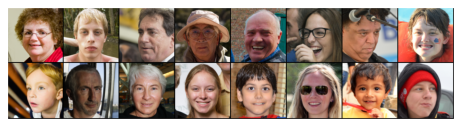

In [14]:
show_batch(train_dl)

## Часть 2. Построение и обучение модели (2 балла)

Сконструируйте генератор и дискриминатор. Помните, что:
* дискриминатор принимает на вход изображение (тензор размера `3 x image_size x image_size`) и выдает вероятность того, что изображение настоящее (тензор размера 1)

* генератор принимает на вход тензор шумов размера `latent_size x 1 x 1` и генерирует изображение размера `3 x image_size x image_size`

In [15]:
latent_size = 128

In [16]:
class GaussianNoise(nn.Module):                         # Try noise just for real or just for fake images.
    def __init__(self, std=0.1, decay_rate=0):
        super().__init__()
        self.std = std
        self.decay_rate = decay_rate

    def decay_step(self):
        self.std = max(self.std - self.decay_rate, 0)

    def forward(self, x):
        if self.training:
            return x + torch.empty_like(x).normal_(std=self.std)
        else:
            return x

In [17]:
class ConvLayer(nn.Module):
     def __init__(self, mode, in_channels, out_channels, kernel_size, stride, padding, bias=False):
          super(ConvLayer,self).__init__()

          if mode == 'conv':

              self.move = nn.Sequential(
                GaussianNoise(),
                nn.Conv2d(in_channels,out_channels,kernel_size=kernel_size,
                          stride=stride,padding=padding, bias=bias),
                nn.BatchNorm2d(out_channels),
                nn.ReLU()
                )
              
          elif mode == 'deconv':
              self.move = nn.Sequential(
                nn.ConvTranspose2d(in_channels,out_channels,kernel_size=kernel_size,
                                   stride=stride,padding=padding, bias=bias),
                nn.BatchNorm2d(out_channels),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Dropout(p=0.3)
                )

     def forward(self,inputs):
         outputs=self.move(inputs)
         return outputs

In [18]:
class Generator(nn.Module):                         # Try noise just for real or just for fake images.
    def __init__(self, latent_size):
        super().__init__()
        self.latent_size = latent_size
        self.move = nn.Sequential(
            
            nn.Linear(self.latent_size, 1024*8*8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Unflatten(1, (1024, 8, 8)),

            ConvLayer('deconv', 1024, 512, kernel_size=4, stride=2, padding=1, bias=False), #8x8 -> 16x16
            ConvLayer('deconv', 512, 256, kernel_size=4, stride=2, padding=1, bias=False),  #16x16 -> 32x32
            ConvLayer('deconv', 256, 128, kernel_size=4, stride=2, padding=1, bias=False),  #32x32 -> 64x64
            nn.ConvTranspose2d(128, 3, kernel_size=4, stride=2, padding=1, bias=False), #64x64 -> 128x128
            nn.Tanh())

    def forward(self, inputs):
         outputs=self.move(inputs)
         return outputs

In [19]:
class Discriminator(nn.Module):                         # Try noise just for real or just for fake images.
    def __init__(self):
        super().__init__()
        self.move = nn.Sequential(

            ConvLayer('conv', 3, 128, kernel_size=4, stride=2, padding=1, bias=False), #128x128 -> 64x64
            ConvLayer('conv', 128, 256, kernel_size=4, stride=2, padding=1, bias=False),  #64x64 -> 32x32
            ConvLayer('conv', 256, 512, kernel_size=4, stride=2, padding=1, bias=False),   #32x32 -> 16x16
            ConvLayer('conv', 512, 1, kernel_size=4, stride=2, padding=1, bias=False),   #16x16 -> 8x8

            nn.Dropout(p=0.2),
            nn.Flatten(),
            GaussianNoise(),
            nn.Linear(64, 1),
            nn.Sigmoid())

    def forward(self, inputs):
         outputs=self.move(inputs)
         return outputs

In [20]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [21]:
fixed_latent = torch.randn(batch_size, latent_size, device=device)

Перейдем теперь к обучению нашего GANа. Алгоритм обучения следующий:
1. Учим дискриминатор:
  * берем реальные изображения и присваиваем им метку 1
  * генерируем изображения генератором и присваиваем им метку 0
  * обучаем классификатор на два класса

2. Учим генератор:
  * генерируем изображения генератором и присваиваем им метку 0
  * предсказываем дискриминаторором, реальное это изображение или нет


В качестве функции потерь берем бинарную кросс-энтропию

In [ ]:
state = torch.load(f"/content/model_150_epochs.pth")

In [ ]:
model["discriminator"].load_state_dict(state['D_model'])
model["generator"].load_state_dict(state['G_model'])
optimizer["discriminator"].load_state_dict(state['D_optim'])
optimizer["generator"].load_state_dict(state['G_optim'])
scheduler["discriminator"].load_state_dict(state['D_sched'])
scheduler["generator"].load_state_dict(state['G_sched'])
losses_g = state['losses_g']
losses_d = state['losses_d']
real_scores = state['r_scores']
fake_scores = state['f_scores']

In [22]:
lr_d = 0.0001
lr_g = 0.0003
epochs = 150

model = {
    "discriminator": Discriminator(),
    "generator": Generator(latent_size = latent_size)}

criterion = {
    "discriminator": nn.BCELoss(),
    "generator": nn.BCELoss()}

optimizer = {
    "discriminator": torch.optim.Adam(model["discriminator"].parameters(), lr=lr_d, betas=(0.5, 0.999)),
    "generator": torch.optim.Adam(model["generator"].parameters(), lr=lr_g, betas=(0.5, 0.999))}

scheduler = {
    "discriminator": torch.optim.lr_scheduler.MultiStepLR(optimizer["discriminator"], milestones = [30, 80, 120], gamma = 0.6),
    "generator": torch.optim.lr_scheduler.MultiStepLR(optimizer["generator"], milestones = [30, 80, 120], gamma = 0.6)
}


torch.Size([16, 3, 128, 128])


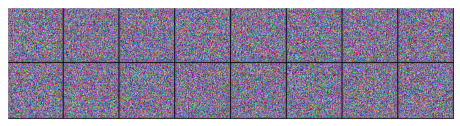

In [23]:
xb = torch.randn(batch_size, latent_size) 
fake_images = model["generator"](xb)
print(fake_images.shape)
show_images(fake_images)

In [24]:
def save_samples(index, latent_tensors, show=True):
    fake_images = model["generator"](latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [88]:
model["discriminator"].to(device)
model["generator"].to(device)

Generator(
  (move): Sequential(
    (0): Linear(in_features=128, out_features=65536, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Unflatten(dim=1, unflattened_size=(1024, 8, 8))
    (3): ConvLayer(
      (move): Sequential(
        (0): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.2, inplace=True)
        (3): Dropout(p=0.3, inplace=False)
      )
    )
    (4): ConvLayer(
      (move): Sequential(
        (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.2, inplace=True)
        (3): Dropout(p=0.3, inplace=False)
      )
    )
    (5): ConvLayer(
      (move): Sequential(
        (0): ConvTranspose2d(256, 

In [ ]:
# Losses & scores
losses_g = []
losses_d = []
real_scores = []
fake_scores = []

In [91]:
def fit(model, criterion, epochs, start_idx=1):
    model["discriminator"].train()
    model["generator"].train()
    torch.cuda.empty_cache()

    for epoch in range(75, epochs):
        loss_d_per_epoch = []
        loss_g_per_epoch = []
        real_score_per_epoch = []
        fake_score_per_epoch = []
        for real_images in tqdm(train_dl):
            real_images = real_images.to(device)
            # Train discriminator
            # Clear discriminator gradients
            optimizer["discriminator"].zero_grad()

            # Pass real images through discriminator
            real_preds = model["discriminator"](real_images)
            real_targets = torch.ones(real_images.size(0), 1, device=device)
            real_loss = criterion["discriminator"](real_preds, real_targets)
            cur_real_score = torch.mean(real_preds).item()
            
            # Generate fake images
            latent = torch.randn(batch_size, latent_size, device=device)
            fake_images = model["generator"](latent)

            # Pass fake images through discriminator
            fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
            fake_preds = model["discriminator"](fake_images)
            fake_loss = criterion["discriminator"](fake_preds, fake_targets)
            cur_fake_score = torch.mean(fake_preds).item()

            real_score_per_epoch.append(cur_real_score)
            fake_score_per_epoch.append(cur_fake_score)

            # Update discriminator weights
            loss_d = real_loss + fake_loss
            loss_d.backward()
            optimizer["discriminator"].step()
            loss_d_per_epoch.append(loss_d.item())

            scheduler["discriminator"].step()


            # Train generator
            # Clear generator gradients
            optimizer["generator"].zero_grad()
            
            # Generate fake images
            latent = torch.randn(batch_size, latent_size, device=device)
            fake_images = model["generator"](latent)
            
            # Try to fool the discriminator
            preds = model["discriminator"](fake_images)
            targets = torch.ones(batch_size, 1, device=device)
            loss_g = criterion["generator"](preds, targets)
            
            # Update generator weights
            loss_g.backward()
            optimizer["generator"].step()
            loss_g_per_epoch.append(loss_g.item())

            scheduler["generator"].step()
            
        # Record losses & scores
        losses_g.append(np.mean(loss_g_per_epoch))
        losses_d.append(np.mean(loss_d_per_epoch))
        real_scores.append(np.mean(real_score_per_epoch))
        fake_scores.append(np.mean(fake_score_per_epoch))
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, 
            losses_g[-1], losses_d[-1], real_scores[-1], fake_scores[-1]))
    
        # Save generated images
        save_samples(epoch+start_idx, fixed_latent, show=False)

        # Save the model

        if (epoch + 1) % 25 == 0:
          state = {
              'D_model': model["discriminator"].state_dict(),
              'G_model': model["generator"].state_dict(),
              'D_optim': optimizer["discriminator"].state_dict(),
              'G_optim': optimizer["generator"].state_dict(),
              'D_sched': scheduler["discriminator"].state_dict(),
              'G_sched': scheduler["generator"].state_dict(),
              'losses_d': losses_d,
              'losses_g': losses_g,
              'r_scores': real_scores,
              'f_scores': fake_scores,
          }
          torch.save(state, f"model_{epoch + 1}_epochs.pth")

In [92]:
fit(model, criterion, epochs)

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [76/150], loss_g: 2.6062, loss_d: 0.4088, real_score: 0.8478, fake_score: 0.1600
Saving generated-images-0076.png


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [77/150], loss_g: 2.4995, loss_d: 0.4176, real_score: 0.8474, fake_score: 0.1643
Saving generated-images-0077.png


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [78/150], loss_g: 2.6204, loss_d: 0.4294, real_score: 0.8436, fake_score: 0.1659
Saving generated-images-0078.png


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [79/150], loss_g: 2.5777, loss_d: 0.3984, real_score: 0.8536, fake_score: 0.1576
Saving generated-images-0079.png


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [80/150], loss_g: 2.5859, loss_d: 0.4171, real_score: 0.8496, fake_score: 0.1609
Saving generated-images-0080.png


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [81/150], loss_g: 2.6097, loss_d: 0.3997, real_score: 0.8541, fake_score: 0.1555
Saving generated-images-0081.png


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [82/150], loss_g: 2.6138, loss_d: 0.3903, real_score: 0.8576, fake_score: 0.1533
Saving generated-images-0082.png


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [83/150], loss_g: 2.6418, loss_d: 0.3805, real_score: 0.8592, fake_score: 0.1495
Saving generated-images-0083.png


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [84/150], loss_g: 2.6436, loss_d: 0.4003, real_score: 0.8537, fake_score: 0.1552
Saving generated-images-0084.png


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [85/150], loss_g: 2.6723, loss_d: 0.3705, real_score: 0.8614, fake_score: 0.1466
Saving generated-images-0085.png


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [86/150], loss_g: 2.6897, loss_d: 0.3938, real_score: 0.8571, fake_score: 0.1518
Saving generated-images-0086.png


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [87/150], loss_g: 2.8279, loss_d: 0.3859, real_score: 0.8596, fake_score: 0.1470
Saving generated-images-0087.png


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [88/150], loss_g: 2.7583, loss_d: 0.3541, real_score: 0.8686, fake_score: 0.1413
Saving generated-images-0088.png


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [89/150], loss_g: 2.7784, loss_d: 0.3986, real_score: 0.8574, fake_score: 0.1502
Saving generated-images-0089.png


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [90/150], loss_g: 2.7583, loss_d: 0.3621, real_score: 0.8676, fake_score: 0.1439
Saving generated-images-0090.png


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [91/150], loss_g: 2.8787, loss_d: 0.3527, real_score: 0.8721, fake_score: 0.1372
Saving generated-images-0091.png


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [92/150], loss_g: 2.7662, loss_d: 0.3984, real_score: 0.8602, fake_score: 0.1508
Saving generated-images-0092.png


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [93/150], loss_g: 2.9060, loss_d: 0.3242, real_score: 0.8794, fake_score: 0.1294
Saving generated-images-0093.png


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [94/150], loss_g: 2.8638, loss_d: 0.3835, real_score: 0.8631, fake_score: 0.1459
Saving generated-images-0094.png


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [95/150], loss_g: 2.9738, loss_d: 0.3048, real_score: 0.8843, fake_score: 0.1225
Saving generated-images-0095.png


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [96/150], loss_g: 2.8865, loss_d: 0.3412, real_score: 0.8753, fake_score: 0.1331
Saving generated-images-0096.png


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [97/150], loss_g: 2.9205, loss_d: 0.3480, real_score: 0.8745, fake_score: 0.1337
Saving generated-images-0097.png


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [98/150], loss_g: 3.0032, loss_d: 0.3454, real_score: 0.8767, fake_score: 0.1332
Saving generated-images-0098.png


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [99/150], loss_g: 2.8925, loss_d: 0.3472, real_score: 0.8743, fake_score: 0.1330
Saving generated-images-0099.png


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [100/150], loss_g: 2.9368, loss_d: 0.3423, real_score: 0.8761, fake_score: 0.1325
Saving generated-images-0100.png


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [101/150], loss_g: 2.9265, loss_d: 0.3561, real_score: 0.8757, fake_score: 0.1311
Saving generated-images-0101.png


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [102/150], loss_g: 3.0846, loss_d: 0.3334, real_score: 0.8787, fake_score: 0.1276
Saving generated-images-0102.png


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [103/150], loss_g: 3.1050, loss_d: 0.2849, real_score: 0.8911, fake_score: 0.1130
Saving generated-images-0103.png


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [104/150], loss_g: 3.1524, loss_d: 0.3407, real_score: 0.8813, fake_score: 0.1288
Saving generated-images-0104.png


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [105/150], loss_g: 3.1103, loss_d: 0.3249, real_score: 0.8831, fake_score: 0.1235
Saving generated-images-0105.png


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [106/150], loss_g: 3.1188, loss_d: 0.3003, real_score: 0.8911, fake_score: 0.1188
Saving generated-images-0106.png


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [107/150], loss_g: 3.1161, loss_d: 0.3343, real_score: 0.8796, fake_score: 0.1272
Saving generated-images-0107.png


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [108/150], loss_g: 3.2202, loss_d: 0.2868, real_score: 0.8926, fake_score: 0.1123
Saving generated-images-0108.png


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [109/150], loss_g: 3.2327, loss_d: 0.3082, real_score: 0.8889, fake_score: 0.1169
Saving generated-images-0109.png


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [110/150], loss_g: 3.2357, loss_d: 0.3097, real_score: 0.8874, fake_score: 0.1179
Saving generated-images-0110.png


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [111/150], loss_g: 3.3294, loss_d: 0.2759, real_score: 0.8982, fake_score: 0.1087
Saving generated-images-0111.png


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [112/150], loss_g: 3.2995, loss_d: 0.2828, real_score: 0.8945, fake_score: 0.1074
Saving generated-images-0112.png


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [113/150], loss_g: 3.2400, loss_d: 0.3094, real_score: 0.8903, fake_score: 0.1181
Saving generated-images-0113.png


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [114/150], loss_g: 3.2932, loss_d: 0.3305, real_score: 0.8822, fake_score: 0.1200
Saving generated-images-0114.png


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [115/150], loss_g: 3.2917, loss_d: 0.3099, real_score: 0.8898, fake_score: 0.1187
Saving generated-images-0115.png


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [116/150], loss_g: 3.4342, loss_d: 0.2677, real_score: 0.9012, fake_score: 0.1044
Saving generated-images-0116.png


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [117/150], loss_g: 3.2470, loss_d: 0.3327, real_score: 0.8857, fake_score: 0.1203
Saving generated-images-0117.png


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [118/150], loss_g: 3.3950, loss_d: 0.3011, real_score: 0.8913, fake_score: 0.1147
Saving generated-images-0118.png


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [119/150], loss_g: 3.4712, loss_d: 0.2844, real_score: 0.8973, fake_score: 0.1057
Saving generated-images-0119.png


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [120/150], loss_g: 3.5567, loss_d: 0.2566, real_score: 0.9069, fake_score: 0.0989
Saving generated-images-0120.png


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [121/150], loss_g: 3.4691, loss_d: 0.2920, real_score: 0.8964, fake_score: 0.1101
Saving generated-images-0121.png


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [122/150], loss_g: 3.4618, loss_d: 0.2672, real_score: 0.9047, fake_score: 0.1015
Saving generated-images-0122.png


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [123/150], loss_g: 3.4018, loss_d: 0.2737, real_score: 0.9014, fake_score: 0.1042
Saving generated-images-0123.png


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [124/150], loss_g: 3.5078, loss_d: 0.2846, real_score: 0.8986, fake_score: 0.1049
Saving generated-images-0124.png


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [125/150], loss_g: 3.6542, loss_d: 0.2921, real_score: 0.8985, fake_score: 0.1068
Saving generated-images-0125.png


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [126/150], loss_g: 3.6344, loss_d: 0.2566, real_score: 0.9074, fake_score: 0.0993
Saving generated-images-0126.png


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [127/150], loss_g: 3.6560, loss_d: 0.2893, real_score: 0.8986, fake_score: 0.1038
Saving generated-images-0127.png


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [128/150], loss_g: 3.5955, loss_d: 0.2845, real_score: 0.8993, fake_score: 0.1057
Saving generated-images-0128.png


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [129/150], loss_g: 3.6686, loss_d: 0.2517, real_score: 0.9073, fake_score: 0.0968
Saving generated-images-0129.png


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [130/150], loss_g: 3.7502, loss_d: 0.2519, real_score: 0.9089, fake_score: 0.0948
Saving generated-images-0130.png


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [131/150], loss_g: 3.8430, loss_d: 0.2260, real_score: 0.9153, fake_score: 0.0871
Saving generated-images-0131.png


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [132/150], loss_g: 3.7274, loss_d: 0.2493, real_score: 0.9112, fake_score: 0.0931
Saving generated-images-0132.png


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [133/150], loss_g: 3.7889, loss_d: 0.2694, real_score: 0.9040, fake_score: 0.1005
Saving generated-images-0133.png


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [134/150], loss_g: 3.8913, loss_d: 0.2509, real_score: 0.9110, fake_score: 0.0932
Saving generated-images-0134.png


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [135/150], loss_g: 3.7098, loss_d: 0.2894, real_score: 0.9005, fake_score: 0.1045
Saving generated-images-0135.png


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [136/150], loss_g: 3.8110, loss_d: 0.2353, real_score: 0.9152, fake_score: 0.0901
Saving generated-images-0136.png


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [137/150], loss_g: 3.8723, loss_d: 0.2697, real_score: 0.9042, fake_score: 0.0984
Saving generated-images-0137.png


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [138/150], loss_g: 3.8516, loss_d: 0.2112, real_score: 0.9215, fake_score: 0.0838
Saving generated-images-0138.png


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [139/150], loss_g: 3.8358, loss_d: 0.2421, real_score: 0.9140, fake_score: 0.0906
Saving generated-images-0139.png


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [140/150], loss_g: 3.8219, loss_d: 0.2919, real_score: 0.9045, fake_score: 0.1027
Saving generated-images-0140.png


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [141/150], loss_g: 3.7724, loss_d: 0.2529, real_score: 0.9082, fake_score: 0.0951
Saving generated-images-0141.png


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [142/150], loss_g: 3.7878, loss_d: 0.2768, real_score: 0.9059, fake_score: 0.0991
Saving generated-images-0142.png


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [143/150], loss_g: 3.9398, loss_d: 0.2276, real_score: 0.9184, fake_score: 0.0874
Saving generated-images-0143.png


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [144/150], loss_g: 3.9699, loss_d: 0.2339, real_score: 0.9168, fake_score: 0.0883
Saving generated-images-0144.png


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [145/150], loss_g: 4.0040, loss_d: 0.2068, real_score: 0.9237, fake_score: 0.0803
Saving generated-images-0145.png


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [146/150], loss_g: 3.8421, loss_d: 0.2745, real_score: 0.9070, fake_score: 0.0984
Saving generated-images-0146.png


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [147/150], loss_g: 3.7895, loss_d: 0.2164, real_score: 0.9212, fake_score: 0.0843
Saving generated-images-0147.png


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [148/150], loss_g: 3.9367, loss_d: 0.2128, real_score: 0.9217, fake_score: 0.0820
Saving generated-images-0148.png


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [149/150], loss_g: 3.8726, loss_d: 0.2658, real_score: 0.9090, fake_score: 0.0979
Saving generated-images-0149.png


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [150/150], loss_g: 4.1331, loss_d: 0.2384, real_score: 0.9173, fake_score: 0.0881
Saving generated-images-0150.png


Постройте графики лосса для генератора и дискриминатора. Что вы можете сказать про эти графики?

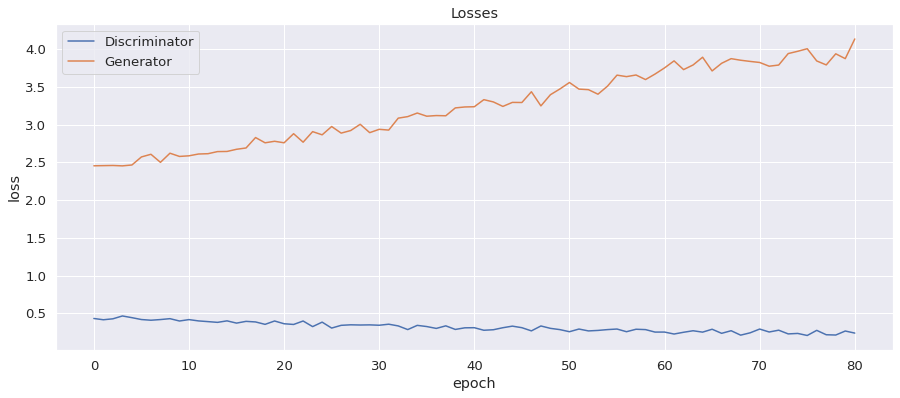

In [93]:
plt.figure(figsize=(15, 6))
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

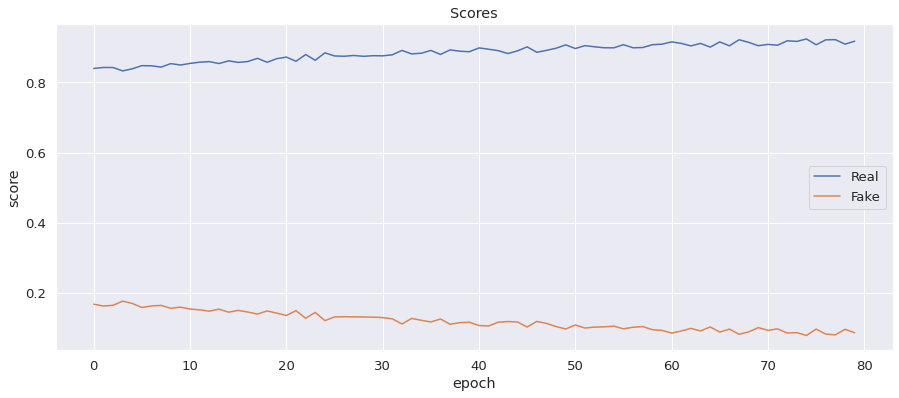

In [94]:
plt.figure(figsize=(15, 6))

plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');

Здесь графики лосса начинаются с 70 эпохи, до 70 эпохи лоссы удалились. По графикам видно, что Дискриминатор медленно но верно "побеждает" Генератор.

## Часть 3. Генерация изображений (1 балл)

Теперь давайте оценим качество получившихся изображений. Напишите функцию, которая выводит изображения, сгенерированные нашим генератором

In [28]:
generated_img = cv2.imread(f'./generated/generated-images-0150.png')
generated_img = generated_img[:, :, [2, 1, 0]]

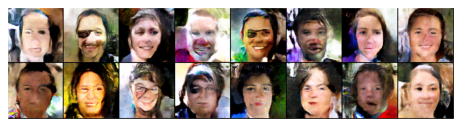

In [29]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_xticks([]); ax.set_yticks([])
ax.imshow(generated_img)

Как вам качество получившихся изображений?

На фоторграфии не особо похоже. Больше напоминает приятные рисунки 7-милетней девочки акварелью)))

## Часть 4. Leave-one-out-1-NN classifier accuracy (6 баллов)

### 4.1. Подсчет accuracy (4 балла)

Не всегда бывает удобно оценивать качество сгенерированных картинок глазами. В качестве альтернативы вам предлагается реализовать следующий подход:
  * Сгенерировать столько же фейковых изображений, сколько есть настоящих в обучающей выборке. Присвоить фейковым метку класса 0, настоящим – 1.
  * Построить leave-one-out оценку: обучить 1NN Classifier (`sklearn.neighbors.KNeighborsClassifier(n_neighbors=1)`) предсказывать класс на всех объектах, кроме одного, проверить качество (accuracy) на оставшемся объекте. В этом вам поможет `sklearn.model_selection.LeaveOneOut`

In [30]:
from sklearn.model_selection import LeaveOneOut
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

In [61]:
size_of_X = int(len(train_files)/5)
X_fake = []
y_fake = np.zeros(size_of_X)
y_real = np.ones(size_of_X)

for i in range(size_of_X):
  xb = torch.randn(1, latent_size) 
  X_fake.append(model['generator'](xb).detach().cpu().numpy().reshape((3*128*128)))

X_fake = np.array(X_fake)

In [62]:
X_real = []
k = 0

for img in train_dl.dataset:
  if k < size_of_X:
    X_real.append(img.detach().cpu().numpy().reshape((3*128*128)))
  k +=1

X_real = np.array(X_real)

In [63]:
y = np.concatenate((y_fake, y_real))
X = np.concatenate((X_fake, X_real))

In [64]:
preds = []

In [65]:
loo = LeaveOneOut()

for train_index, test_index in loo.split(X):

    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    classifier = KNeighborsClassifier(n_neighbors=1)  
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    preds.append(y_pred[0])


In [66]:
print(accuracy_score(y, preds))

0.8550955414012739


Что вы можете сказать о получившемся результате? Какой accuracy мы хотели бы получить и почему?

Идеальным accuracy был бы результат около 0.5. Такое значение свидетельствует о том, что классификатор не может различить сгенерированные и реальные снимки. Полученные результат свидетельствует об обратном. Сгенерированные снимки не достаточно хорошо соответствуют реальным фотографиям.

### 4.2. Визуализация распределений (2 балла)

Давайте посмотрим на то, насколько похожи распределения настоящих и фейковых изображений. Для этого воспользуйтесь методом, снижающим размерность (к примеру, TSNE) и изобразите на графике разным цветом точки, соответствующие реальным и сгенерированным изображенияи

In [67]:
from sklearn.manifold import TSNE
import matplotlib.cm as cm

In [68]:
tsne_representation = TSNE(n_components=2)
X_emb = tsne_representation.fit_transform(X)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


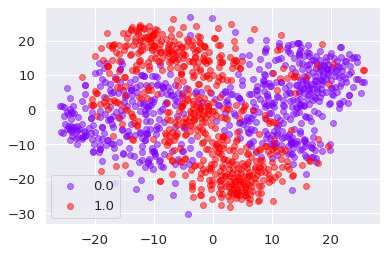

In [71]:
colors = cm.rainbow(np.linspace(0, 1, 2))
for label, c in zip(set(y), colors):
    c=np.array([c])
    X = [X_emb[i][0] for i in range(len(y)) if y[i] == label]
    Y = [X_emb[i][1] for i in range(len(y)) if y[i] == label]
    plt.scatter(X, Y, c=c, alpha=0.5, label=str(label))
plt.legend()

Прокомментируйте получившийся результат:

Видим, что генератор не смог сгенерировать достаточно хорошие снимки. Из облака точек можно выделить правдивые снимки. Это связано с тем, что модель генератора не достаточно сложна, чтобы обмануть дискриминатор.